# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want report that the error of the model at predicting tree cover was x +/- y at the 95% confidence level. 

How confident are we that a certain range around these estimates of tree cover actually contains the true parameter? In other words, what do the error bars look like for precision, recall and f1? How granular can we make these validation assessments for each region/subregion/ecoregion? 

**Steps**
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Visualize error bars


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Quick EDA

In [214]:
df = pd.read_csv('validation-chm.csv')
#df2 = df.copy(deep = True)
#df2['rvalue_1'] = 'Overall'
#df = pd.concat([df, df2])
print(len(df))

8996


In [215]:
#df['tp'] = df['tp'].astype(int)
df['fp'] = df['fp'].astype(int)
#df['fn'] = df['fn'].astype(int)

In [216]:
df.gedi_gte5

0       False
1        True
2        True
3       False
4        True
        ...  
8991     True
8992     True
8993     True
8994     True
8995     True
Name: gedi_gte5, Length: 8996, dtype: bool

In [217]:
np.sum(df['remove'] == 1)

97

In [218]:
df = df[df['remove'] != 1]

In [190]:
df = df[df['gedi_rh95'] >= 3]

In [210]:
df['subregion'] = 'Overall'

## Bootstrap from each scale, calculate scores and confidence intervals

In [219]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a column (scale) 
    and calculates the precisio
    n, recall and f1. Then takes percentiles of the bootstrap 
    to calculate confidence intervals. Returns separate dfs with the scores and CIs.
    '''
    
    # get a list of categories within the scale, dropping categories with less than 5 rows
    #df = df.groupby(scale).filter(lambda x: len(x)>5)   
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
    
                     
    # empty df to store samples, scores and CIs
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80', 'lower_conf_range',
                                      'upper_conf_range'])

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        return precision, recall, f1
    
    # for each category in scale, calculate scores, 
    for i in categories:
        grouped = df[df[scale] == i]
        bootsamples = pd.DataFrame()
        
        for num in range(n):  
            bootstrap = grouped.sample(len(grouped), replace=True)
            #bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1 = calculate_metrics(sum(bootstrap.tp.values), 
                                                      sum(bootstrap.fp.values), 
                                                      sum(bootstrap.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5) 
        p_upper_95, r_upper_95, f1_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5) 
        p_upper_90, r_upper_90, f1_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10) 
        p_upper_80, r_upper_80, f1_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90)
        print(len(grouped2.recall.values))
        lower_conf_range = np.percentile(grouped2.recall.values - grouped2.precision.values,
                                                           2.5)
        upper_conf_range = np.percentile(grouped2.recall.values - grouped2.precision.values,
                                                           97.5)
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80,
                                   'lower_conf_range': lower_conf_range,
                                   'upper_conf_range': upper_conf_range}, ignore_index = True)
        
    # add columns with the mean precision, recall and f1 to CI dataframe (pd can only merge 2 df at a time)
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).precision.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).recall.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).f1.mean().reset_index(), on='category')
    
    # add column with # of samples to CI dataframe
    sample_size = df[scale].value_counts().to_frame().reset_index()
    sample_size.columns = ['category', 'num_samples']
    conf_int = pd.merge(conf_int, sample_size, on='category')

    # returns scores and conf intervals separately
    return val_df, conf_int

In [220]:
subregion_val, subregion_conf = bootstrap(df, 'subregion', 1000)

subregion has 20 subcategories. 20000 samples in total.
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [213]:
subregion_conf['']

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,...,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80,lower_conf_range,upper_conf_range,precision,recall,f1,num_samples
0,subregion,Overall,0.872718,0.88406,0.766364,0.781568,0.817315,0.82815,0.873794,0.882837,...,0.768568,0.778972,0.819432,0.826493,-0.113259,-0.095906,0.878457,0.77388,0.822853,8996


## Visuals: Pointplot + Errorplot

In [221]:
from matplotlib.transforms import ScaledTranslation

def errorplot_precision_recall(conf_df, figsize, title, legend = True):
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    
    plt.rc('font', **font)

    
    fig, ax = plt.subplots(figsize=figsize)
    #ax.figure(figsize=figsize)

    x_p = conf_df.precision * 100
    x_r = conf_df.recall * 100
    y = conf_df.category
    #print(y)

    # define precalculated error bars
    p_lower_95 = (conf_df['precision'] - conf_df['p_lower_95']) * 100
    p_upper_95 = (conf_df['p_upper_95'] - conf_df['precision'] ) * 100
    p_lower_90 = (conf_df['precision'] - conf_df['p_lower_90'] ) * 100
    p_upper_90 = (conf_df['p_upper_90'] - conf_df['precision'] ) * 100
    p_lower_80 = (conf_df['precision'] - conf_df['p_lower_80'] ) * 100
    p_upper_80 = (conf_df['p_upper_80'] - conf_df['precision'] ) * 100
    
    # define precalculated error bars
    r_lower_95 = (conf_df['recall'] - conf_df['r_lower_95'] ) * 100
    r_upper_95 = (conf_df['r_upper_95'] - conf_df['recall'] ) * 100
    r_lower_90 = (conf_df['recall'] - conf_df['r_lower_90'] ) * 100
    r_upper_90 = (conf_df['r_upper_90'] - conf_df['recall'] ) * 100
    r_lower_80 = (conf_df['recall'] - conf_df['r_lower_80'] ) * 100
    r_upper_80 = (conf_df['r_upper_80'] - conf_df['recall']) * 100
    
    trans1 = ax.transData + ScaledTranslation(-6/72, 0, fig.dpi_scale_trans)
    trans2 = ax.transData + ScaledTranslation(+6/72, 0, fig.dpi_scale_trans)

    # plot error bars (3x for precision, 3x for recall)
    #print(y, x_p, x_r)
    ax.errorbar(y, x_p, yerr=[p_lower_95, p_upper_95], fmt='.', ecolor='lightcoral', transform=trans1,
                 elinewidth=3, markerfacecolor='grey', markeredgecolor='grey', capsize=3, )
    ax.errorbar(y, x_p, yerr=[p_lower_90, p_upper_90], fmt='.', ecolor='orangered', transform=trans1,
                 elinewidth=6, markerfacecolor='grey', markeredgecolor='grey', capsize=3)
    ax.errorbar(y, x_p, yerr=[p_lower_80, p_upper_80], fmt='.', ecolor='crimson', transform=trans1,
                 elinewidth=12, markerfacecolor='grey', markeredgecolor='grey', capsize=3)
    
    ax.errorbar(y, x_r, yerr=[r_lower_95, r_upper_95], fmt='.', ecolor='lightsteelblue',  transform=trans2,
                 elinewidth=3, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.errorbar(y, x_r, yerr=[r_lower_90, r_upper_90], fmt='.', ecolor='royalblue',  transform=trans2,
                 elinewidth=6, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.errorbar(y, x_r, yerr=[r_lower_80, r_upper_80], fmt='.', ecolor='mediumblue',  transform=trans2,
                 elinewidth=12, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.set(xlabel=None, ylabel=None)
    
    # create y axis labels
    #print(conf_df.num_samples.apply(str))
    labels = (': '.join(item) for item in zip(conf_df.category, conf_df.num_samples.apply(str)))
    labels = [x for x in labels]
    plt.xticks(range(len(conf_df)), labels, rotation=90)
    plt.yticks([x for x in range(20, 110, 10)])
    
    # format title and legend
    plt.title(f"{title}")
    plt.grid(axis='y', linestyle='-', linewidth=.5)
    ci80_b = mpatches.Patch(color='mediumblue', label="80% Conf. PA")
    ci80_r = mpatches.Patch(color='crimson', label="80% Conf. UA")
    ci90_b = mpatches.Patch(color='royalblue', label="90% Conf. PA")
    ci90_r = mpatches.Patch(color='orangered', label="90% Conf. UA")
    ci95_b = mpatches.Patch(color='lightsteelblue', label="95% Conf. PA")
    ci95_r = mpatches.Patch(color='lightcoral', label="95% Conf. UA")
    mean_p = mpatches.Patch(color='grey', edgecolor = 'black', label="Mean UA")
    mean_r = mpatches.Patch(color='gold', label="Mean PA")
    if legend:
        plt.legend(handles=[ci80_b, ci90_b, ci95_b, mean_r, ci80_r, ci90_r, ci95_r, mean_p], 
                   title='Key', 
                   bbox_to_anchor=(1.05, 1), 
                   loc='upper left');
    plt.ylim(20, 100)
    
    return None

In [222]:
means = (subregion_conf.precision + subregion_conf.recall) / 2
means

0     0.787659
1     0.605102
2     0.887908
3     0.831215
4     0.589804
5     0.855048
6     0.782761
7     0.664513
8     0.776231
9     0.929006
10    0.759469
11    0.649982
12    0.853585
13    0.857079
14    0.810877
15    0.723956
16    0.867668
17    0.838934
18    0.664503
19    0.673264
dtype: float64

In [223]:
np.mean(subregion_conf['p_upper_95'] - subregion_conf['p_lower_95'])

0.09192048545433455

### Subregion

In [224]:
means = (subregion_conf.f1)
means = np.argsort(means)
#means = 19 - means
#print(means)
#print(np.max(means))
subregion_conf = subregion_conf.reindex(means)
subregion_conf

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,...,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80,lower_conf_range,upper_conf_range,precision,recall,f1,num_samples
f1,,,,,,,,,,,,,,,,,,,,,
1,subregion,Northern Africa,0.601347,0.884820,0.244540,0.596837,0.350613,0.686981,0.635468,0.870389,...,0.323847,0.548681,0.443978,0.656934,-0.490454,-0.169435,0.769059,0.441146,0.556554,234
4,subregion,Southern Africa,0.577566,0.822627,0.336900,0.593454,0.433350,0.682329,0.600734,0.807408,...,0.379999,0.552893,0.475678,0.645073,-0.343396,-0.137366,0.708871,0.470738,0.564256,125
11,subregion,Central Asia,0.694687,0.857331,0.431624,0.569054,0.542159,0.675847,0.716170,0.849392,...,0.464652,0.551664,0.574548,0.659631,-0.352937,-0.205053,0.790547,0.509417,0.619074,220
7,subregion,Eastern Africa,0.758452,0.835913,0.480952,0.571767,0.597432,0.674145,0.767287,0.830604,...,0.498642,0.558049,0.612050,0.661587,-0.325495,-0.224032,0.800318,0.528709,0.636451,488
19,subregion,Western Asia,0.756793,0.860388,0.457474,0.615874,0.577776,0.704801,0.763240,0.853218,...,0.480655,0.587979,0.599437,0.684326,-0.361379,-0.187446,0.811901,0.534627,0.643748,272
18,subregion,Australia and New Zealand,0.734083,0.809575,0.513972,0.597656,0.611012,0.680582,0.740753,0.802778,...,0.529674,0.582909,0.623108,0.669103,-0.258482,-0.168765,0.772870,0.556135,0.646617,578
15,subregion,Western Africa,0.819299,0.905127,0.510478,0.642272,0.634415,0.744104,0.831011,0.900370,...,0.532396,0.624014,0.658847,0.729978,-0.358514,-0.220938,0.868779,0.579132,0.694423,191
10,subregion,Southern Europe,0.804309,0.873536,0.623668,0.728360,0.709680,0.789273,0.811113,0.870614,...,0.641555,0.712170,0.723495,0.775378,-0.218744,-0.109568,0.841169,0.677769,0.750384,195
8,subregion,Southern Asia,0.812290,0.877810,0.660298,0.750856,0.734103,0.802232,0.817746,0.874139,...,0.675979,0.735363,0.746488,0.792099,-0.189152,-0.096690,0.846870,0.705591,0.769602,557


In [225]:
subregion_conf = subregion_conf.reset_index(drop = True)
reind = np.flip(np.arange(0, 20, 1))
subregion_conf = subregion_conf.reindex(reind)

<ipython-input-221-58adb68c78f1>:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mean_p = mpatches.Patch(color='grey', edgecolor = 'black', label="Mean UA")


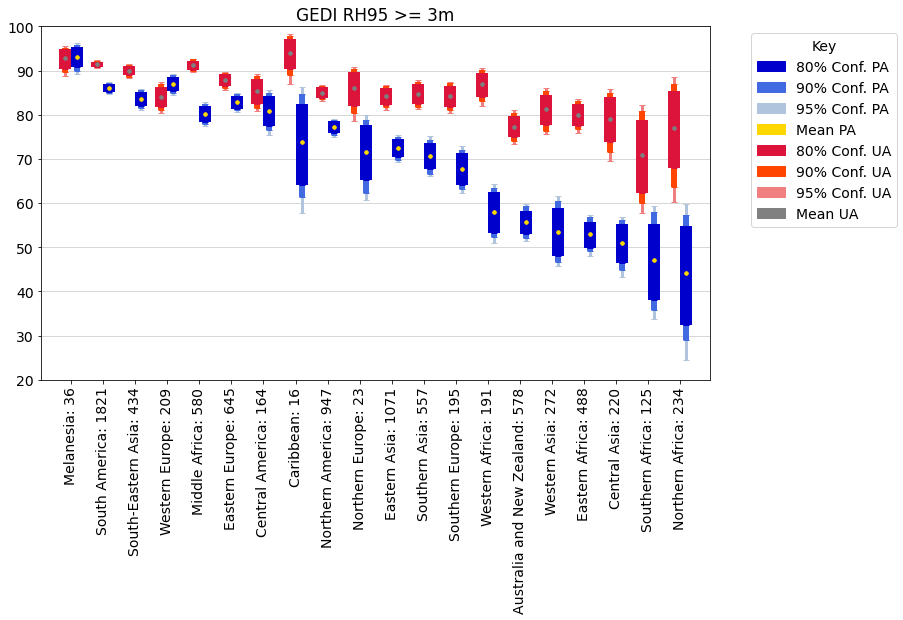

In [226]:
errorplot_precision_recall(subregion_conf, (12, 6.5), 'GEDI RH95 >= 3m', True)
#plt.savefig("subregion_chm_3m.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("subregion_chm_3m.png", dpi = 200, bbox_inches = "tight")

<ipython-input-193-58adb68c78f1>:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mean_p = mpatches.Patch(color='grey', edgecolor = 'black', label="Mean UA")


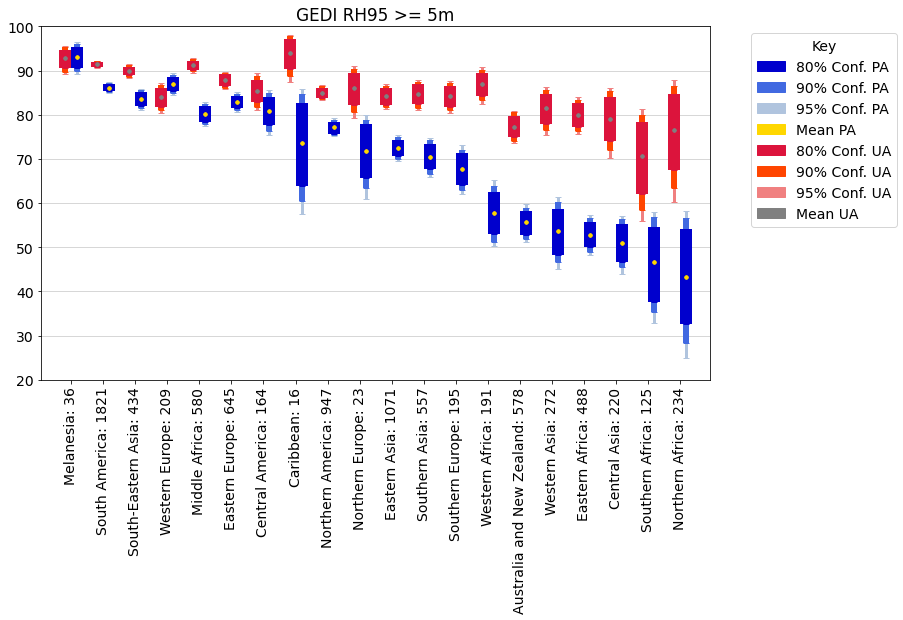

In [204]:
errorplot_precision_recall(subregion_conf, (12, 6.5), 'GEDI RH95 >= 5m', True)
#plt.savefig("subregion.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("subregion_chm_5m.png", dpi = 200, bbox_inches = "tight")

19                    Melanesia
18                South America
17           South-Eastern Asia
16                Middle Africa
15               Eastern Europe
14               Western Europe
13              Central America
12             Northern America
11                    Caribbean
10                Southern Asia
9               Northern Europe
8                  Eastern Asia
7               Southern Europe
6     Australia and New Zealand
5                Western Africa
4                  Western Asia
3                Eastern Africa
2               Southern Africa
1                  Central Asia
0               Northern Africa
Name: category, dtype: object
19                    Melanesia
18                South America
17           South-Eastern Asia
16                Middle Africa
15               Eastern Europe
14               Western Europe
13              Central America
12             Northern America
11                    Caribbean
10                Southern Asia
9         

<ipython-input-56-6afda9dbf706>:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mean_p = mpatches.Patch(color='grey', edgecolor = 'black', label="Mean UA")


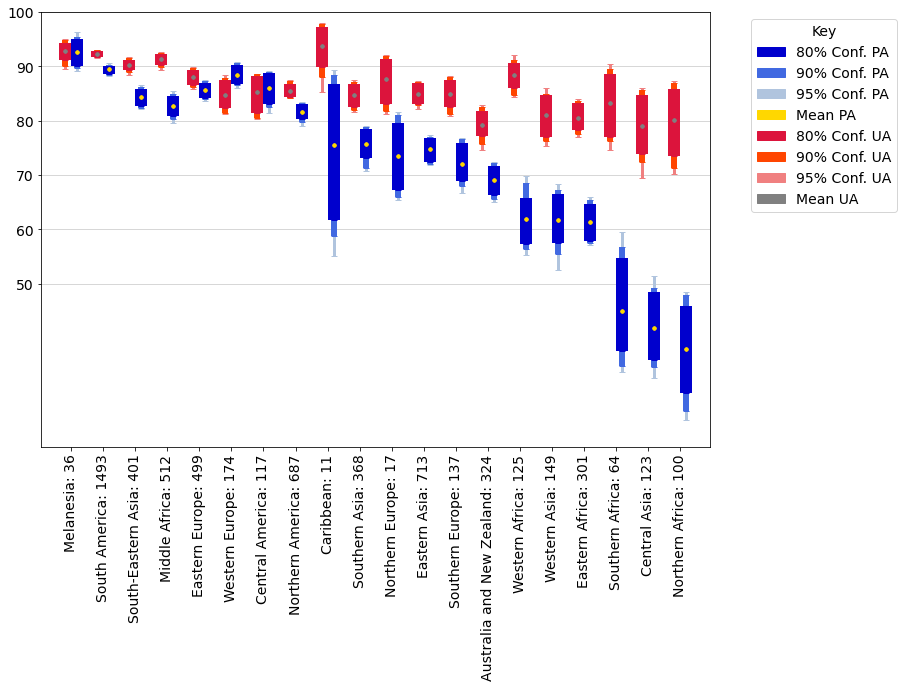

In [60]:
errorplot_precision_recall(subregion_conf, (12, 8), '', True)
#plt.savefig("subregion.pdf", dpi = 200, bbox_inches = "tight")
#plt.savefig("subregion.png", dpi = 200, bbox_inches = "tight")

In [24]:
lulc_conf.head(10)
lulc_conf = lulc_conf.reindex([3, 0, 1, 2, 4, 5, 6])
lulc_conf = lulc_conf.reset_index(drop = True)
lulc_conf = lulc_conf.dropna()

NameError: name 'lulc_conf' is not defined

In [24]:
lulc_conf.head(10)
lulc_conf['num_samples'] = lulc_conf['num_samples'].astype(int)

0    Shrub/scrub/otherland
1                    Urban
2                   Forest
3                Grassland
4        Mosaic vegetation
5                 Cropland
Name: category, dtype: object
0    Shrub/scrub/otherland
1                    Urban
2                   Forest
3                Grassland
4        Mosaic vegetation
5                 Cropland
Name: category, dtype: object


<ipython-input-18-44532e777235>:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mean_p = mpatches.Patch(color='grey', edgecolor = 'black', label="Mean UA")


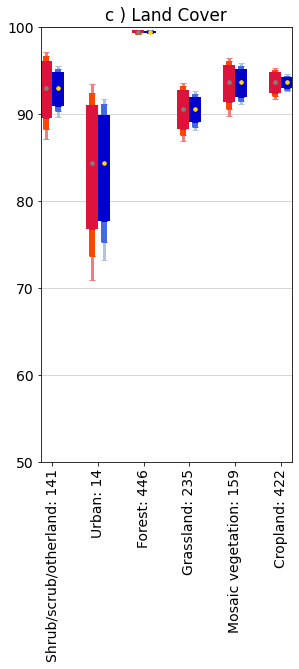

In [25]:
errorplot_precision_recall(lulc_conf, (6*.75,8), 'c ) Land Cover', False)
plt.savefig("lulc.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("lulc.png", dpi = 200, bbox_inches = "tight")

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


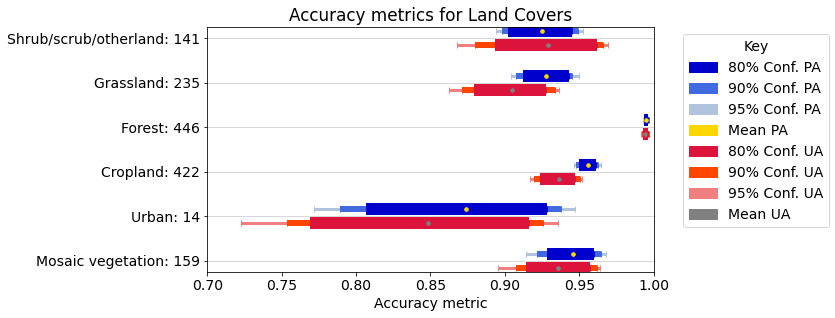

In [47]:
errorplot_precision_recall(lulc_conf, (8,4.5), 'Land Covers')
plt.savefig("lulc.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("lulc.png", dpi = 200, bbox_inches = "tight")

### Biomes

In [ ]:
errorplot_precision_recall(biome_conf, (10,6), 'Biomes')

### Tree Class

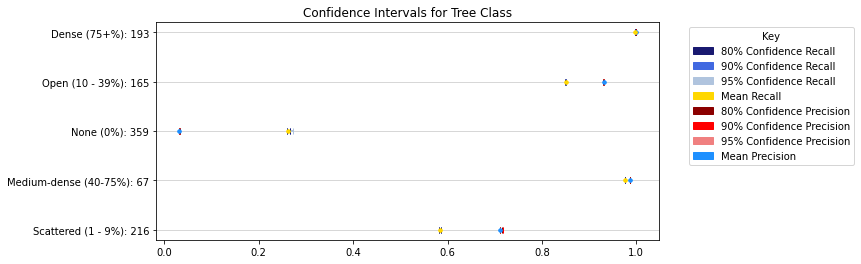

In [69]:
errorplot_precision_recall(treeclass_conf, (9,4), 'Tree Class')

### Ecoregion

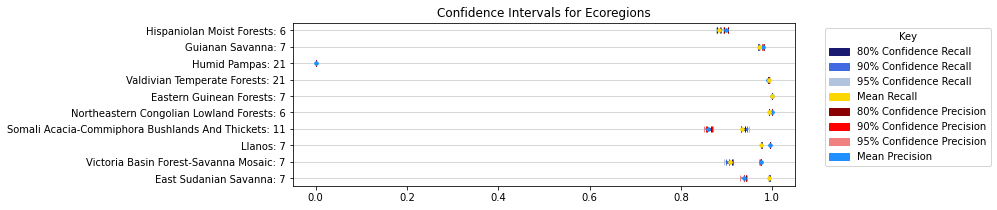

In [80]:
errorplot_precision_recall(ecoreg_conf[15:25], (9,3), 'Ecoregions')

### Country

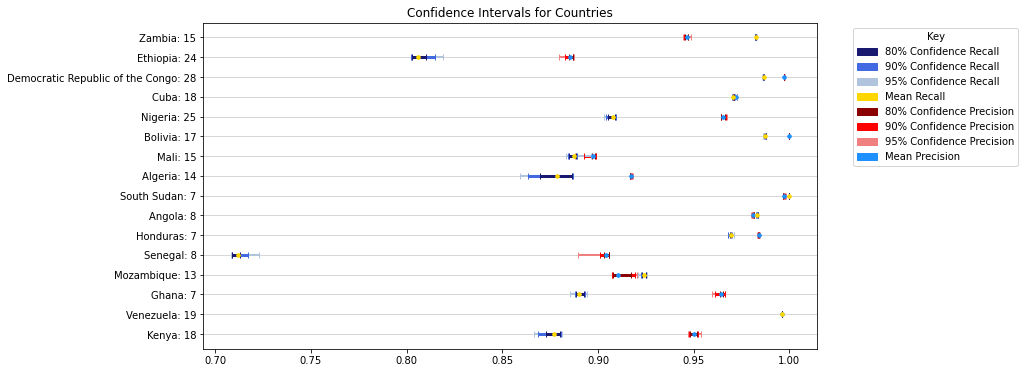

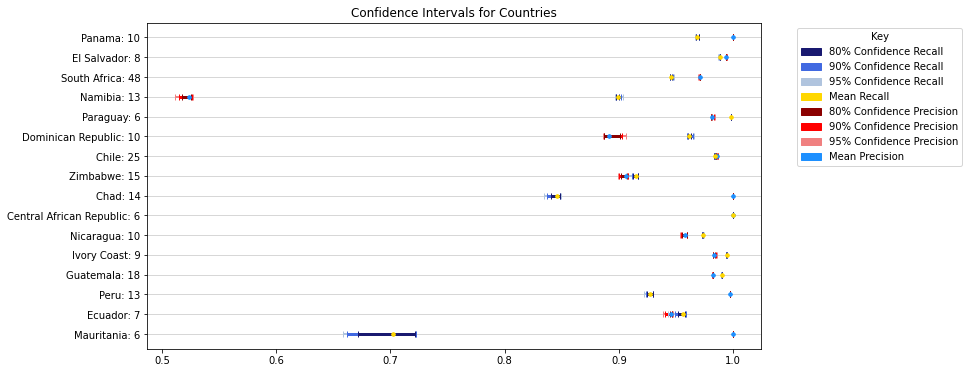

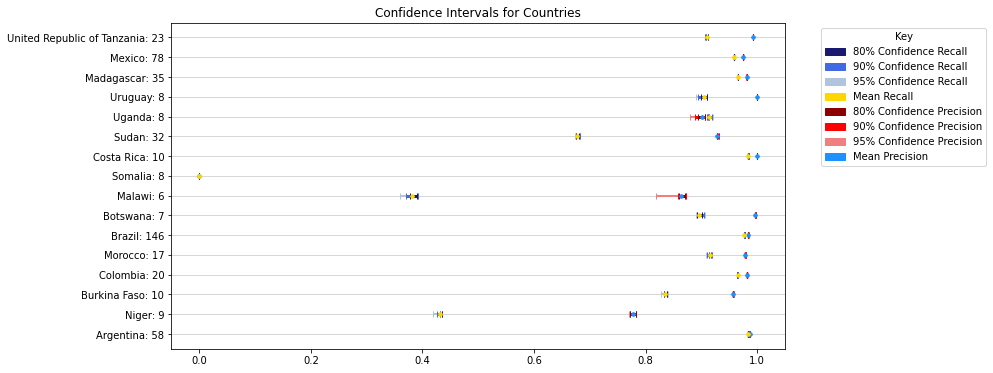

In [79]:
errorplot_precision_recall(country_conf[:16], (11,6), 'Countries')
errorplot_precision_recall(country_conf[16:32], (11,6), 'Countries')
errorplot_precision_recall(country_conf[32:], (11,6), 'Countries')

### Conclusions